## Non-normal Naive Bayes Classifier

In this section, we will implement a non-normal Naive Bayes classifier. Unlike the standard Naive Bayes classifier, which assumes that the features follow a normal distribution, the non-normal Naive Bayes classifier makes no such assumptions.

Having explored the dataset beforehand, we know that the features do not follow a normal distribution. However, most of them seem to follow parametric distributions such as exponential, Poisson, or multinomial distributions. For that reason, three different non-normal Naive Bayes classifiers will be implemented: In the first one, we will use histogram-based probability density estimation for each continuous feature. In the second one, we will use kernel density estimation (KDE) for each continuous feature. Finally, in the third one, we will attempt to discover the underlying parametric distribution of each feature and use that information to build the classifier.

Let us start by loading the data, removing unnecessary columns, preprocessing the rest, and splitting it into training and test sets. This part is similar to what we did in the previous sections. However, because the density estimation methods we will use in this section are tunable (e.g., number of bins in histograms, bandwidth in KDE), we will also implement a K-fold cross-validation procedure to find the best hyperparameters for each method.

In [3]:
import pandas as pd
import numpy as np


df = pd.read_csv("../data/processed/train_no_preprocess.csv")
# Uncomment the following lines if loading unprocessed data
# df = df.drop(columns=["EventId", "KaggleSet", "KaggleWeight"])
# df.replace(-999.0, np.nan, inplace=True)  # Missing values are represented as -999.0
df.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,90.901,85.570,75.316,40.945,NaN,NaN,NaN,1.869,3.111,135.816,...,1,42.605,-1.962,-2.519,NaN,NaN,NaN,42.605,0.589395,b
1,133.477,3.669,99.223,227.121,2.243,365.016,2.278,1.223,3.539,440.917,...,2,173.249,-0.759,2.545,87.317,-3.002,-2.594,260.566,0.000461,s
2,115.111,26.919,77.658,50.266,NaN,NaN,NaN,2.691,3.655,133.495,...,1,53.895,0.685,-0.613,NaN,NaN,NaN,53.895,0.623627,b
3,NaN,83.642,74.642,25.176,NaN,NaN,NaN,2.646,25.176,53.813,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.772114,b
4,81.958,7.074,46.894,90.979,0.952,83.883,-0.226,1.626,17.517,174.686,...,2,80.028,-0.456,-1.902,33.561,0.496,-0.555,113.589,0.418760,b


In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Label", "Weight"])
weight = df["Weight"]  # Only used to compute the AMS metric
y = df["Label"]
# Stratify to maintain class distribution
X_train, X_test, weight_train, weight_test, y_train, y_test = train_test_split(
    X, weight, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, weight_train.shape, weight_test.shape, y_train.shape, y_test.shape

((556401, 30), (139101, 30), (556401,), (139101,), (556401,), (139101,))

### Non-normal Naive Bayes Classifier with Histogram-based Estimation

Let us start by implementing a trivial non-normal Naive Bayes classifier that uses histogram-based probability density estimation for each continuous feature. The idea is to create histograms for each feature conditioned on the class labels and use these histograms to estimate the likelihoods during prediction.

> **Note:** Because we are going to implement several non-gaussian Naive Bayes classifiers, instead of creating separate classes for each one, as we had originally, 
> we have created a single class `BespokeNB` that can accept any probability estimator for each feature. That way, we can easily create different non-gaussian Naive Bayes classifiers by simply passing different estimators to the `BespokeNB` class.
>
> This implementation has been thoroughly tested and is available in the `src/naive_bayes` directory of the repository.

In [5]:
import sys
import os

sys.path.append(os.path.abspath("../"))
from src.naive_bayes import BespokeNB, HistogramEstimator, CategoricalEstimator

This implementation has a `n_bins` hyperparameter that specifies the number of bins to use for the histograms. We will use K-fold cross-validation to find the best value for this hyperparameter. But first, let us perform a quick training run with `bin_count` set to 10, and all the learning data to see how well this classifier performs without any hyperparameter tuning.

Because there are some missing values in the dataset, which this method doesn't allow, we will drop any rows that contain missing values for any methods that do not support N/A.

In [6]:
X_clean_train = X_train.dropna()
y_clean_train = y_train[X_clean_train.index]
weight_clean_train = weight_train[X_clean_train.index]
X_clean_test = X_test.dropna()
y_clean_test = y_test[X_clean_test.index]
weight_clean_test = weight_test[X_clean_test.index]
X_clean_train.shape, y_clean_train.shape, X_clean_test.shape, y_clean_test.shape

((152112, 30), (152112,), (37855, 30), (37855,))

Note that this could lead to a significant reduction in the size of the dataset, as well as a potential bias if the missingness is not completely at random (which we have strong reasons to believe it is not), and could lead to errors in the inference runtime.

Categorical features will be handled by a `CategoricalEstimator`, which is a simple probability estimator that estimates the probabilities of each category based on their frequencies in the training data.

In [7]:
categorical_features = df.columns.get_indexer(["PRI_jet_num"]).tolist()

In [ ]:
model = BespokeNB(
    estimators={
        j: CategoricalEstimator() if j in categorical_features else HistogramEstimator(bins=10)
        for j in range(X_clean_train.shape[1])
    }
)
model.fit(X_clean_train.to_numpy(), y_clean_train.to_numpy())

y_pred = model.predict(X_clean_test.to_numpy())
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_clean_test.to_numpy(), y_pred)
report = classification_report(y_clean_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

Accuracy: 0.6699
              precision    recall  f1-score   support

           b       0.63      0.93      0.75     20152
           s       0.82      0.38      0.52     17703

    accuracy                           0.67     37855
   macro avg       0.73      0.65      0.63     37855
weighted avg       0.72      0.67      0.64     37855



An alternative, more safe approach to removing missing values would be to remove the columns that contain missing values instead of the rows. This can potentially lead to an increase of both the error and the bias, as we would be removing potentially useful features. However, it would not reduce the size of the dataset, and it is less likely that it would not lead to errors during inference (in the training dataset, only 11 features have any missing values).

In [9]:
columns_with_na = X.columns[X.isna().any()].tolist()
columns_with_na

['DER_mass_MMC',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_lep_eta_centrality',
 'PRI_jet_leading_pt',
 'PRI_jet_leading_eta',
 'PRI_jet_leading_phi',
 'PRI_jet_subleading_pt',
 'PRI_jet_subleading_eta',
 'PRI_jet_subleading_phi']

In [10]:
X_col_clean_train = X_train.drop(columns=columns_with_na)
X_col_clean_test = X_test.drop(columns=columns_with_na)

In [11]:
model = BespokeNB(
    estimators={
        j: CategoricalEstimator() if j in categorical_features else HistogramEstimator(bins=10)
        for j in range(X_col_clean_train.shape[1])
    }
)
model.fit(X_col_clean_train.to_numpy(), y_train.to_numpy())

y_pred = model.predict(X_col_clean_test.to_numpy())
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test.to_numpy(), y_pred)
report = classification_report(y_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

Accuracy: 0.6604
              precision    recall  f1-score   support

           b       0.72      0.80      0.76     91576
           s       0.50      0.40      0.44     47525

    accuracy                           0.66    139101
   macro avg       0.61      0.60      0.60    139101
weighted avg       0.64      0.66      0.65    139101



Finally, let us introduce a new version of the HistogramNB which will accept N/A values. This version will estimate each feature's distribution using a combination of their histogram and the missingness pattern. We will define the probability density* function as follows:
$$
    p(x_i|y=c) = 
    \begin{cases}
        p^{NA} & \text{if } x_i \text{ is missing} \\
        (1-p^{NA})\cdot f_{i,c}(x_i) & \text{if } x_i \text{ is observed}
    \end{cases}
$$

Where $p^{NA}$ is the probability of missingness for feature $i$ given class $c$, and $f_{i,c}(x_i)$ is the probability density function estimate for feature $i$ given class $c$. This way, we can account for the missingness in our density estimates. Interestingly enough, this approach also accounts for the possibility of Laplace smoothing, as we can add a small amount to $p^{NA}$ such that the model remains robust even to missing data in features not seen missing in the training set.

> **Note:** We originally called this version of the `HistogramNB` as `RobustHistogramNB`, but we have decided to integrate it into the `BespokeNB` class instead, simply by passing a `RobustHistogramEstimator` for each feature.

In [12]:
from src.naive_bayes import RobustHistogramEstimator, RobustCategoricalEstimator

model = BespokeNB(
    estimators={
        j: RobustCategoricalEstimator() if j in categorical_features else RobustHistogramEstimator(bins=10)
        for j in range(X_train.shape[1])
    }
)

model.fit(X_train.to_numpy(), y_train.to_numpy())

y_pred = model.predict(X_test.to_numpy())
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test.to_numpy(), y_pred)
report = classification_report(y_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

Accuracy: 0.6702
              precision    recall  f1-score   support

           b       0.73      0.80      0.76     91576
           s       0.52      0.42      0.46     47525

    accuracy                           0.67    139101
   macro avg       0.62      0.61      0.61    139101
weighted avg       0.66      0.67      0.66    139101



The last implementation of the histogram-based Naive Bayes classifier that we want to check is one that assumes complete independence between all features, except for the single categorical feature `PRI_jet_num`, which has four possible values (0, 1, 2, 3). For this feature, we will create separate histograms for each of its possible values, conditioned on the class labels. This way, we can capture the dependencies between this categorical feature and the continuous features.

This implementation is not strictly speaking a Naive Bayes classifier, as it does not assume complete independence between all features. However, it is still a simple and effective way to model the data, and it can potentially lead to better performance than the standard histogram-based Naive Bayes classifier.

> **Note:** The implementation of the `BespokeNB` class was altered to support this functionality. Specifically, it was modified to accept a list of categorical features, and during the fitting process, it creates separate estimators for each unique combination of values of these categorical features, conditioned on the class labels. During prediction, it uses the appropriate estimator based on the value of the categorical feature for each sample. All continuous features are still assumed to be independent from one another, and use their respective estimators as usual.
>
> We called this custom classifier `CategoricalAwareBespokeNB`, and can be found under `src/naive_bayes/__init__.py`.

In [13]:
from src.naive_bayes import CategoricalAwareBespokeNB

model = CategoricalAwareBespokeNB(
    estimators={
        j: RobustHistogramEstimator(bins=10)  # No need for the RobustCategoricalEstimator here. It's handled internally
        for j in range(X_train.shape[1])
        if j not in categorical_features
    },
    categorical_features=categorical_features,
)
model.fit(X_train.to_numpy(), y_train.to_numpy())

c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\.venv\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges


,estimators,"{0: <src.naive_ba...001C3BDEDE2D0>, 1: <src.naive_ba...001C3BDEDE630>, 2: <src.naive_ba...001C3CA651970>, 3: <src.naive_ba...001C3BDE82870>, ...}"
,categorical_features,[22]
,laplace_smoothing,1e-09


Before proceeding, let us explore the prediction of the histograms of this model.

In [14]:
for var in [
    "_priors",
    "_categorical_combinations",
    "_categorical_combination_probabilities",
    "categorical_features",
    "num_features",
    "num_classes",
    "classes_",
]:
    print(f"{var}: {getattr(model, var)}")

_priors: [0.65833814 0.34166186]
_categorical_combinations: [[0.]
 [1.]
 [2.]
 [3.]]
_categorical_combination_probabilities: [[0.45446355 0.30157794 0.14970789 0.09425061]
 [0.29642138 0.32210246 0.30170278 0.07977338]]
categorical_features: [22]
num_features: 30
num_classes: 2
classes_: ['b' 's']


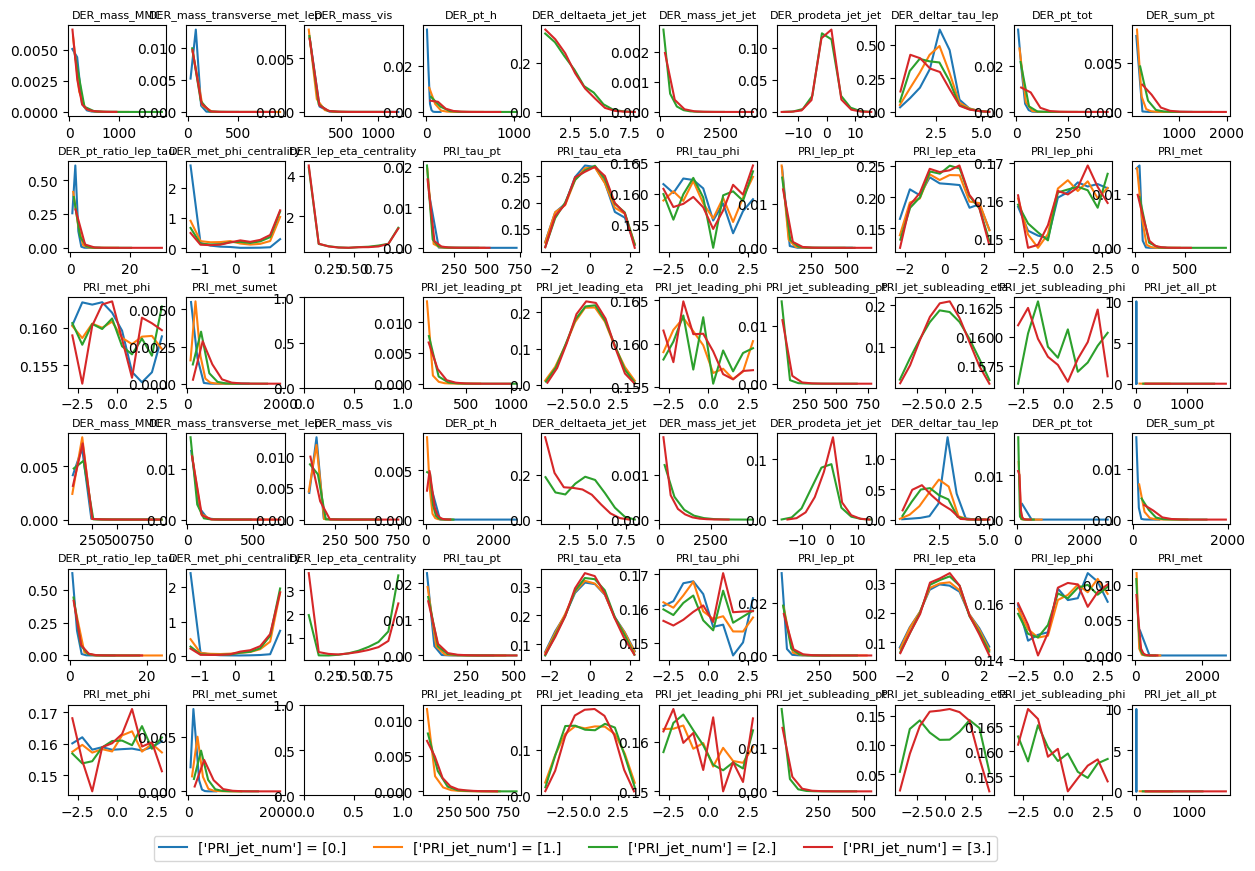

In [15]:
import matplotlib.pyplot as plt
import math
from src.naive_bayes import RobustHistogramEstimator

# Plot the class histograms for each categorical combination and each class
num_cols = model.num_features // 3
num_rows_per_class = math.ceil(model.num_features / num_cols)
label_template = f"{str(df.columns[model.categorical_features].tolist())} = {{cat_comb}}"
fig, ax = plt.subplots(model.num_classes * num_rows_per_class, num_cols, figsize=(15, 10))
for class_idx, class_label in enumerate(model.classes_):
    for feature_idx in range(model.num_features):
        if feature_idx in model.categorical_features:
            continue  # Skip categorical features
        for comb_idx, cat_comb in enumerate(model._categorical_combinations):
            # We know, from how we built the model, that all estimators are RobustHistogramEstimators
            estimator: RobustHistogramEstimator = model._fitted_estimators[class_idx][comb_idx][feature_idx]
            ax_index = np.s_[class_idx * num_rows_per_class + feature_idx // num_cols, feature_idx % num_cols]
            ax[ax_index].plot(
                (estimator._bin_edges[:-1] + estimator._bin_edges[1:]) / 2,  # Midpoints
                estimator._histogram,
                color=f"C{comb_idx}",
                label=label_template.format(cat_comb=cat_comb),
            )
            ax[ax_index].set_title(df.columns[feature_idx], fontsize=8)
            # ax[ax_index].set_xlabel("Value")
            # ax[ax_index].set_ylabel("Density")
# plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.legend(ncol=len(model._categorical_combinations), loc="lower left", bbox_to_anchor=(-10, -0.8))

In [16]:
y_pred = model.predict(X_test.to_numpy())
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test.to_numpy(), y_pred)
report = classification_report(y_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

Accuracy: 0.7252
              precision    recall  f1-score   support

           b       0.79      0.79      0.79     91576
           s       0.60      0.60      0.60     47525

    accuracy                           0.73    139101
   macro avg       0.69      0.69      0.69    139101
weighted avg       0.73      0.73      0.73    139101



> **Note:** Originally, we had an error on the implementation of this very non-standard version of the Naive Bayes classifier, and that, together with the complexity of its code, lead us to abandon its use, as well as any further exploration of similar models. However, we have fixed the error and simplified the code a lot, and found that this model can actually perform quite well, better than the previous histogram-based models. For that reason, we have decided to include it in this section.

### Non-normal Naive Bayes Classifier with Kernel Density Estimation

Next, we will implement a non-normal Naive Bayes classifier that uses kernel density estimation (KDE) for each continuous feature. KDE is a non-parametric way to estimate the probability density function of a random variable famously used for Naive Bayes classifiers (Trevor Hastie et al.). We will use Gaussian kernels for this purpose.

#### Definition of KDE-based Naive Bayes Classifier

Let $(x_1, ..., x_n)$ be a set of independent and identically distributed samples drawn from some unknown probability density function $f$. The kernel density estimate $\hat{f}(x)$ of $f$ at a point $x$ is given by:

$$
\hat{f}(x) = \frac{1}{n} \sum_{i=1}^{n} K_h(x - x_i)
$$

where $K_h$ is the kernel function with bandwidth $h$, a smoothing parameter related to the variance of the estimator. For a Gaussian kernel, this is defined as:

$$
K_h(u) = \frac{1}{\sqrt{2\pi h^2}} \exp\left(-\frac{u^2}{2h^2}\right)
$$



> **Note:** Thanks to the modular implementation of the `BespokeNB` class, implementing this classifier is straightforward. We simply needed to create a `KDEstimator` class that implements the `fit` and `predict` methods, and then pass instances of this class to the `BespokeNB` class for each continuous feature.
>
> We created several versions of the `KDEstimator` class, such as `GaussianKDEstimator` and `RobustGaussianKDEstimator`. They all can be found under `src/naive_bayes/kde_estimators/`. Note that they are defined as Mixins to allow for easy creation of new estimators with different kernels or bandwidth selection methods.

Let us first try training a `BespokeNB` model with `GaussianKDEstimator` instances for each continuous feature, cleaning the data by removing any rows with missing values.

> **Important Note:** All the KDE-based estimators implemented in this project use lazy evaluation, meaning that they store all the training data and use it to compute the new density estimates during prediction. This can lead to high memory usage and slow prediction times, especially for large datasets.
>
> For that reason, the testing step of these models must always be done in batches, to avoid running out of memory.

In [17]:
from src.naive_bayes import EagerGaussianKDEstimator

model = BespokeNB(
    estimators={
        j: CategoricalEstimator() if j in categorical_features else EagerGaussianKDEstimator(num_points=3000)
        for j in range(X_clean_train.shape[1])
    }
)

model.fit(X_clean_train.to_numpy(), y_clean_train.to_numpy())

y_pred = model.predict(X_clean_test)
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_clean_test.to_numpy(), y_pred)
report = classification_report(y_clean_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

Accuracy: 0.7932
              precision    recall  f1-score   support

           b       0.79      0.83      0.81     20152
           s       0.79      0.75      0.77     17703

    accuracy                           0.79     37855
   macro avg       0.79      0.79      0.79     37855
weighted avg       0.79      0.79      0.79     37855



c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but BespokeNB was fitted without feature names
  warnings.warn(


Let us also test an implementation of the Gaussian KDE estimator but this time dropping the columns with missing values instead of the rows.

In [18]:
from src.naive_bayes import EagerGaussianKDEstimator

model = BespokeNB(
    estimators={
        j: CategoricalEstimator() if j in categorical_features else EagerGaussianKDEstimator(num_points=3000)
        for j in range(X_col_clean_train.shape[1])
    }
)

model.fit(X_col_clean_train.to_numpy(), y_train.to_numpy())

y_pred = model.predict(X_col_clean_test)
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test.to_numpy(), y_pred)
report = classification_report(y_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but BespokeNB was fitted without feature names
  warnings.warn(


Accuracy: 0.7366
              precision    recall  f1-score   support

           b       0.82      0.78      0.80     91576
           s       0.60      0.66      0.63     47525

    accuracy                           0.74    139101
   macro avg       0.71      0.72      0.71    139101
weighted avg       0.74      0.74      0.74    139101



Finally, let us test a robust version of the Gaussian KDE estimator that can handle missing values directly, as explained in the previous section for the histogram-based estimator.

In [19]:
from src.naive_bayes import RobustEagerGaussianKDEstimator

model = BespokeNB(
    estimators={
        j: (
            RobustCategoricalEstimator()
            if j in categorical_features
            else RobustEagerGaussianKDEstimator(num_points=3000)
        )
        for j in range(X_train.shape[1])
    }
)

model.fit(X_train.to_numpy(), y_train.to_numpy())

y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test.to_numpy(), y_pred)
report = classification_report(y_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but BespokeNB was fitted without feature names
  warnings.warn(


Accuracy: 0.7165
              precision    recall  f1-score   support

           b       0.80      0.76      0.78     91576
           s       0.58      0.62      0.60     47525

    accuracy                           0.72    139101
   macro avg       0.69      0.69      0.69    139101
weighted avg       0.72      0.72      0.72    139101



And finally the categorical-aware version of the KDE-based Naive Bayes classifier.

In [20]:
from src.naive_bayes import RobustEagerGaussianKDEstimator, CategoricalAwareBespokeNB

model = CategoricalAwareBespokeNB(
    estimators={
        j: RobustEagerGaussianKDEstimator()  # No need for the RobustCategoricalEstimator here. It's handled internally
        for j in range(X_train.shape[1])
    },
    categorical_features=categorical_features,
)

model.fit(X_train.to_numpy(), y_train.to_numpy())

y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test.to_numpy(), y_pred)
report = classification_report(y_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\src\naive_bayes\kde_estimators\__init__.py:15: UserWarning: Not enough data points to compute bandwidth. Using arbitrary value of 1.0.
  warnings.warn("Not enough data points to compute bandwidth. Using arbitrary value of 1.0.")
c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\src\naive_bayes\kde_estimators\__init__.py:256: UserWarning: All data points are NaN. Density estimation cannot be computed. Using empty density.
  warnings.warn("All data points are NaN. Density estimation cannot be computed. Using empty density.")
c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\src\naive_bayes\kde_estimators\__init__.py:275: RuntimeWarning: invalid value encountered in divide
  distances = (midpoints[:, np.newaxis] - non_nan_X[np.newaxis, :]) / bandwidth
c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but CategoricalAwareBespokeNB

Accuracy: 0.7699
              precision    recall  f1-score   support

           b       0.78      0.90      0.84     91576
           s       0.73      0.52      0.61     47525

    accuracy                           0.77    139101
   macro avg       0.76      0.71      0.72    139101
weighted avg       0.76      0.77      0.76    139101



To compare with the previous models, let us explore the histogram estimations of this model as well.

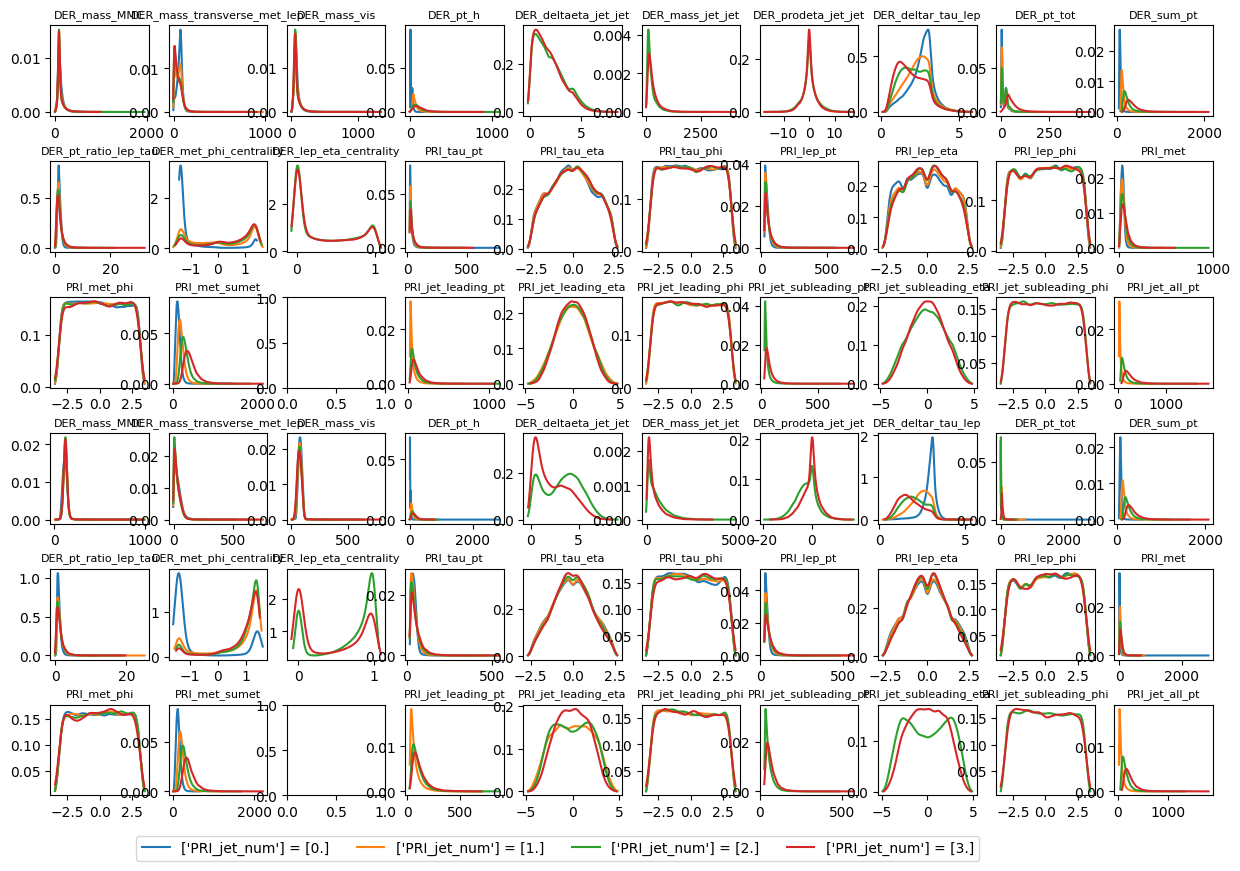

In [21]:
import matplotlib.pyplot as plt
import math
from src.naive_bayes import RobustEagerGaussianKDEstimator

# Plot the class histograms for each categorical combination and each class
num_cols = model.num_features // 3
num_rows_per_class = math.ceil(model.num_features / num_cols)
label_template = f"{str(df.columns[model.categorical_features].tolist())} = {{cat_comb}}"
fig, ax = plt.subplots(model.num_classes * num_rows_per_class, num_cols, figsize=(15, 10))
for class_idx, class_label in enumerate(model.classes_):
    for feature_idx in range(model.num_features):
        if feature_idx in model.categorical_features:
            continue  # Skip categorical features
        for comb_idx, cat_comb in enumerate(model._categorical_combinations):
            # We know, from how we built the model, that all estimators are RobustEagerGaussianKDEstimator
            estimator: RobustEagerGaussianKDEstimator = model._fitted_estimators[class_idx][comb_idx][feature_idx]
            ax_index = np.s_[class_idx * num_rows_per_class + feature_idx // num_cols, feature_idx % num_cols]
            ax[ax_index].plot(
                (estimator._bin_edges[:-1] + estimator._bin_edges[1:]) / 2,  # Midpoints
                estimator._density,
                color=f"C{comb_idx}",
                label=label_template.format(cat_comb=cat_comb),
            )
            ax[ax_index].set_title(df.columns[feature_idx], fontsize=8)
            # ax[ax_index].set_xlabel("Value")
            # ax[ax_index].set_ylabel("Density")
# plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.legend(ncol=len(model._categorical_combinations), loc="lower left", bbox_to_anchor=(-10, -0.8))

### Non-normal Naive Bayes Classifier with Parametric Distribution Fitting

Finally, we will implement a non-normal Naive Bayes classifier that attempts to discover the underlying parametric distribution of each feature and uses that information to build the classifier.

> **Note:** By proposal of the Prof. Lluís Belanche, instead of trying several different parametric distributions and selecting the best-fitting one, we will use a Box-Cox transformation for each feature and class combination to transform the data into something that resembles a normal distribution. Then, we will use a standard Gaussian Naive Bayes classifier on the transformed data.
>
> To do so, we will first fit an off-the-shelf Gaussian Naive Bayes classifier for reference, and implement a `BoxCoxGaussianEstimator` class that will perform the Box-Cox transformation and then fit a Gaussian estimator on the transformed data.

In [22]:
from src.naive_bayes import GaussianEstimator

model = BespokeNB(
    estimators={
        j: CategoricalEstimator() if j in categorical_features else GaussianEstimator() for j in range(X_train.shape[1])
    }
)

model.fit(X_clean_train.to_numpy(), y_clean_train.to_numpy())

y_pred = model.predict(X_clean_test.to_numpy())
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_clean_test.to_numpy(), y_pred)
report = classification_report(y_clean_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

Accuracy: 0.7389
              precision    recall  f1-score   support

           b       0.79      0.69      0.74     20152
           s       0.69      0.79      0.74     17703

    accuracy                           0.74     37855
   macro avg       0.74      0.74      0.74     37855
weighted avg       0.75      0.74      0.74     37855



In [23]:
from src.naive_bayes import GaussianEstimator

model = BespokeNB(
    estimators={
        j: CategoricalEstimator() if j in categorical_features else GaussianEstimator()
        for j in range(X_col_clean_train.shape[1])
    }
)

model.fit(X_col_clean_train.to_numpy(), y_train.to_numpy())

y_pred = model.predict(X_col_clean_test.to_numpy())
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test.to_numpy(), y_pred)
report = classification_report(y_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

Accuracy: 0.7148
              precision    recall  f1-score   support

           b       0.78      0.79      0.79     91576
           s       0.59      0.57      0.58     47525

    accuracy                           0.71    139101
   macro avg       0.68      0.68      0.68    139101
weighted avg       0.71      0.71      0.71    139101



In [24]:
from src.naive_bayes import RobustGaussianEstimator

model = BespokeNB(
    estimators={
        j: CategoricalEstimator() if j in categorical_features else RobustGaussianEstimator()
        for j in range(X_train.shape[1])
    }
)

model.fit(X_train.to_numpy(), y_train.to_numpy())

y_pred = model.predict(X_test.to_numpy())
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test.to_numpy(), y_pred)
report = classification_report(y_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

Accuracy: 0.7347
              precision    recall  f1-score   support

           b       0.76      0.88      0.81     91576
           s       0.66      0.45      0.54     47525

    accuracy                           0.73    139101
   macro avg       0.71      0.67      0.68    139101
weighted avg       0.72      0.73      0.72    139101



In [25]:
from src.naive_bayes import RobustGaussianEstimator

model = CategoricalAwareBespokeNB(
    estimators={
        j: RobustGaussianEstimator()  # No need for the RobustCategoricalEstimator here. It's handled internally
        for j in range(X_train.shape[1])
    },
    categorical_features=categorical_features,
)

model.fit(X_train.to_numpy(), y_train.to_numpy())

y_pred = model.predict(X_test.to_numpy())
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test.to_numpy(), y_pred)
report = classification_report(y_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\.venv\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\.venv\Lib\site-packages\numpy\_core\_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\mirxm\Storage\Work\MDS\S3\AML\HiggsBosonATLAS\.venv\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divi

Accuracy: 0.7437
              precision    recall  f1-score   support

           b       0.77      0.88      0.82     91576
           s       0.67      0.49      0.56     47525

    accuracy                           0.74    139101
   macro avg       0.72      0.68      0.69    139101
weighted avg       0.73      0.74      0.73    139101



Now let's, finally, fit the box-cox based Naive Bayes classifier and evaluate its performance.

In [26]:
from src.naive_bayes import BoxCoxGaussianEstimator

model = BespokeNB(
    estimators={
        j: CategoricalEstimator() if j in categorical_features else BoxCoxGaussianEstimator()
        for j in range(X_train.shape[1])
    }
)

model.fit(X_clean_train.to_numpy(), y_clean_train.to_numpy())

y_pred = model.predict(X_clean_test.to_numpy())
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_clean_test.to_numpy(), y_pred)
report = classification_report(y_clean_test.to_numpy(), y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

ValueError: Data must be positive.

## References

- Hastie, T., Tibshirani, R., & Friedman, J. (2001). The Elements of Statistical Learning: Data Mining, Inference, and Prediction: with 200 full-color illustrations. New York: Springer.